In [1]:
import torch
import math
import matplotlib.pyplot as plt
import random

## loading and pp

In [2]:
#names = open('names.txt', 'r').read().splitlines()
names = open('names_lower.txt', 'r').read().splitlines()

chars = list(sorted(set(''.join(names))))

chars.append('.')

char_to_idx = {c: i+1 for i, c in enumerate(chars)}
char_to_idx['.'] = 0  # '.' is the end of name marker
idx_to_char = {i: c for c, i in char_to_idx.items()}

## Bigram count approach

In [3]:
M = torch.zeros(27, 27,dtype=torch.float32)

In [4]:

for name in names:
    name = ['.'] + list(name.lower()) + ['.']  # Append '.' to mark end of name
    tuples = zip(name, name[1:]) 
    for a, b in tuples:
        i = char_to_idx[a]
        j = char_to_idx[b]
        M[i, j] += 1

M += 1

In [5]:
P = M / M.sum(dim=1, keepdim=True)

(-0.5, 26.5, 26.5, -0.5)

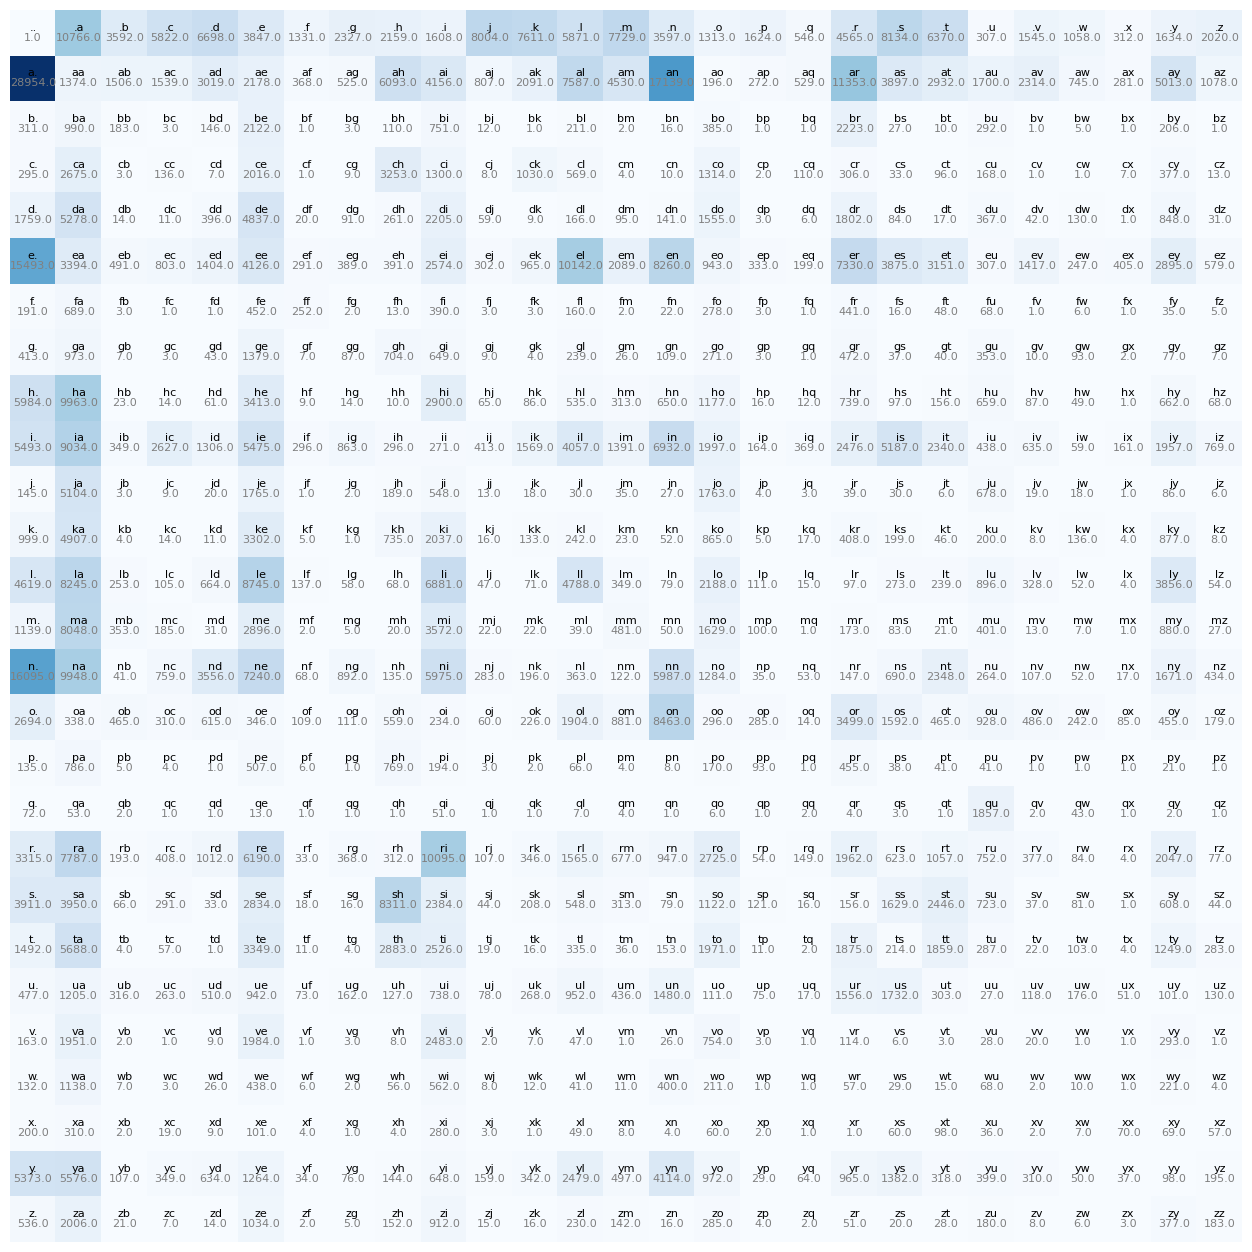

In [6]:
plt.figure(figsize=(16, 16))
plt.imshow(M, cmap='Blues')
for i in range(27):
    for j in range(27):
        str = idx_to_char[i] + idx_to_char[j]
        plt.text(j, i, str, ha='center', va='bottom', fontsize=8, color='black')
        plt.text(j, i, M[i,j].item(), ha='center', va='top', color='gray', fontsize=8)
plt.axis('off')

In [7]:
g = torch.Generator()

In [8]:
for i in range(20):

    name = ""
    prev_id = 0
    while True:
        next_id = torch.multinomial(P[prev_id], num_samples=1, replacement=True, generator=g)
        if next_id.item() == 0:
            break
        name += idx_to_char[next_id.item()]
        prev_id = next_id.item()
    #name = ''.join(name[1:])  # Remove the initial '.' and join the rest
    print(name)

trinnniy
storaya
kawia
jalon
telieri
beontielera
miverdeadamispiete
stely
g
kan
z
ca
nzynkriasonaiaveetonnnolayandelmban
onki
dort
hala
de
vanean
arynaya
mopamyen


In [9]:
# Loss function

total_log_prob = 0.0
n = 0

for name in names:
    name = ['.'] + list(name.lower()) + ['.']
    log_prob = 0.0
    for a, b in zip(name, name[1:]):
        n += 1
        i = char_to_idx[a]
        j = char_to_idx[b]
        log_prob += torch.log(P[i, j])
    total_log_prob += log_prob

avg_log_prob = total_log_prob / n
avg_loss = -avg_log_prob.item()

print(f"Average loss: {avg_loss:.4f}")

Average loss: 2.4583


## NN

In [10]:
import torch.nn.functional as F

In [11]:
xs,ys = [], []

for name in names:
    name = ['.'] + list(name.lower()) + ['.']
    tuples = zip(name, name[1:])
    for a, b in tuples:
        i = char_to_idx[a]
        j = char_to_idx[b]
        xs.append(i)
        ys.append(j)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xenc = F.one_hot(xs, num_classes=27).float()
yenc = F.one_hot(ys, num_classes=27).float()

In [12]:
w = torch.randn(27, 27) 
w.requires_grad = True

In [13]:
i = 0

for i in range(100):
    logits = xenc @ w
    probs = logits.softmax(dim=1)

    loss = -torch.sum(yenc * torch.log(probs)) / len(xs)
    w.grad = None  # Reset gradients before backward pass
    loss.backward()

    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item():.4f}")
    i += 1

    w.data -= 1 * w.grad  # Gradient descent step

Iteration 0, Loss: 3.7653


In [14]:
for i in range(20):
    name = ""
    prev_id = 0
    while True:
        enc = F.one_hot(torch.tensor(prev_id), num_classes=27).float()
        logits = enc @ w
        probs = logits.softmax(dim=0)
        next_id = torch.multinomial(probs, num_samples=1, replacement=True, generator=g)
        if next_id.item() == 0:
            break
        name += idx_to_char[next_id.item()]
        prev_id = next_id.item()
    print(name)

iyluon
ewvcbxyuriyzq
csennzfxxzyoonton
upliuijpwtkyevatxbzhonnolzhablcpvwodzy
maxhjlzhzdvronqsivlohhaijvvoopi
wtrlerwiqgaiy
ptai

ukja
aisfxzbgqwelinqbganszapwgxgxktqkkdzv

jqwnalgxyonaolg
jst
xhdvrwvrqwrkyckzzofzqtril
treq

cgqsbqsfmdfcpz
vjpsjvvkkoqbe
rpuu
pkkuozgxgmiwn


## MLP

### Formatting input data & labels

In [15]:
# build dataset

def build_dataset(block_size):
    X, Y = [], []
    for name in names:
        name = list(name.lower()) + ['.']
        context = [0] * block_size
        for char in name:
            idx = char_to_idx[char]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)

    n = len(X)
    random_indices = list(range(n))
    random.shuffle(random_indices)
    X = X[random_indices]
    Y = Y[random_indices]
    
    train_size = int(0.8 * n)
    dev_size = int(0.1 * n)
    
    X_train, Y_train = X[:train_size], Y[:train_size]
    X_dev, Y_dev = X[train_size:train_size + dev_size], Y[train_size:train_size + dev_size]
    X_test, Y_test = X[train_size + dev_size:], Y[train_size + dev_size:]
    
    return (X_train, Y_train), (X_dev, Y_dev), (X_test, Y_test)

In [34]:
# call the function to build the dataset
block_size = 4
(X_train, Y_train), (X_dev, Y_dev), (X_test, Y_test) = build_dataset(block_size)

In [35]:
X_train.shape, Y_train.shape

(torch.Size([604463, 4]), torch.Size([604463]))

In [36]:
X_dev.shape, Y_dev.shape

(torch.Size([75557, 4]), torch.Size([75557]))

In [39]:
# Init
embed_size = 10
layer_size = 250

w1_scale = 0.1
w1_scale = 5/3 / (block_size * embed_size) ** 0.5
print(f"w1_scale: {w1_scale:.4f}")

w2_scale = 5/3 / layer_size ** 0.5
print(f"w2_scale: {w2_scale:.4f}")

C = torch.rand((27, embed_size))
C.requires_grad = True
W1 = torch.randn((block_size * embed_size, layer_size)) * w1_scale
W1.requires_grad = True
#b1 = torch.randn(layer_size) * 0.005
#b1.requires_grad = True

bn1_scale = torch.ones((1, layer_size))
bn1_scale.requires_grad = True
bn1_shift = torch.zeros((1, layer_size))
bn1_shift.requires_grad = True

bnmean_running = torch.zeros((1, layer_size))
bnmean_running.requires_grad = False
bnstd_running = torch.ones((1, layer_size))
bnstd_running.requires_grad = False

W2 = torch.randn((layer_size, 27)) * w2_scale
W2.requires_grad = True
b2 = torch.randn(27) * 0
b2.requires_grad = True
#parameters = [C, W1, b1, W2, b2, bn1_scale, bn1_shift]
parameters = [C, W1, W2, b2, bn1_scale, bn1_shift]

w1_scale: 0.2635
w2_scale: 0.1054


In [40]:
# Optimization loop
lossi = []

max_steps = 300000
batch_size = 48
#learning_rate = 0.005

for i in range (max_steps):

    # minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch = X_train[idxs]
    Y_batch = Y_train[idxs]

    if i % 10000 == 0:
        print(f"Iteration {i}, Loss: {loss.item():.4f}")
    # Zero gradients
    for param in parameters:
        param.grad = None
    # Forward pass
    emb = C[X_batch]
    emb_flat = emb.view(emb.shape[0], -1)  # Flatten the embedding

    pretanh = emb_flat @ W1
    # Apply batch normalization
    mean = pretanh.mean(dim=0, keepdim=True)
    std = pretanh.std(dim=0, keepdim=True)

    # Update running mean and std
    with torch.no_grad():
        bnmean_running = 0.99 * bnmean_running + 0.01 * mean
        bnstd_running = 0.99 * bnstd_running + 0.01 * std

    pretanh = (pretanh - mean) / (std + 1e-5)
    pretanh = pretanh * bn1_scale + bn1_shift  # Scale and shift

    h = torch.tanh(pretanh)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch)
    # Backward pass
    loss.backward()
    # Update parameters
    learning_rate = 0.1 if i < 100000 else 0.01  # Adjust learning rate
    with torch.no_grad():
        for param in parameters:
            param -= learning_rate * param.grad

    lossi.append(loss.log10().item())


# calibrate batch norm at end of training

with torch.no_grad():
    # forward pass
    emb = C[X_train]
    emb_flat = emb.view(emb.shape[0], -1)  # Flatten the embedding
    pretanh = emb_flat @ W1
    # Apply batch normalization
    bn_mean = pretanh.mean(dim=0, keepdim=True)
    bn_std = pretanh.std(dim=0, keepdim=True)

Iteration 0, Loss: 2.3104
Iteration 10000, Loss: 2.3291
Iteration 20000, Loss: 2.3475
Iteration 30000, Loss: 2.0334
Iteration 40000, Loss: 2.4653
Iteration 50000, Loss: 2.1797
Iteration 60000, Loss: 2.3239
Iteration 70000, Loss: 2.3061
Iteration 80000, Loss: 1.9219
Iteration 90000, Loss: 1.9876
Iteration 100000, Loss: 1.7256
Iteration 110000, Loss: 2.0814
Iteration 120000, Loss: 2.3269
Iteration 130000, Loss: 2.2891
Iteration 140000, Loss: 2.2400
Iteration 150000, Loss: 1.9767
Iteration 160000, Loss: 2.0379
Iteration 170000, Loss: 2.2402
Iteration 180000, Loss: 2.1126
Iteration 190000, Loss: 1.9999
Iteration 200000, Loss: 2.3204
Iteration 210000, Loss: 1.8619
Iteration 220000, Loss: 1.9748
Iteration 230000, Loss: 1.8475
Iteration 240000, Loss: 2.3476
Iteration 250000, Loss: 2.1273
Iteration 260000, Loss: 1.9312
Iteration 270000, Loss: 2.0356
Iteration 280000, Loss: 2.0693
Iteration 290000, Loss: 2.1492


In [45]:
for i in range (20):
    context = [0] * block_size
    name = ""
    while True:
        emb = C[torch.tensor(context)]
        emb_flat = emb.view(1, -1)  # Flatten the embedding
        pretanh = emb_flat @ W1
        pretanh = (pretanh - bnmean_running) / (bnstd_running + 1e-5)
        pretanh = pretanh * bn1_scale + bn1_shift  # Scale and shift
        h = torch.tanh(pretanh)
        logits = h @ W2
        probs = logits.softmax(dim=1)
        next_id = torch.multinomial(probs, num_samples=1, replacement=True)
        if next_id.item() == 0:
            break
        name += idx_to_char[next_id.item()]
        context = context[1:] + [next_id.item()]
    print(name)

kalie
shaqwonn
nika
dwyngwena
sptabon
delfalsizya
victor
nikoz
hail
vander
jodonnichontrion
makow
deiz
jimbu
nomarr
wanety
baboly
sophiniqul
chyschite
sveph


In [43]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'dev': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]
    emb = C[x]
    emb_flat = emb.view(emb.shape[0], -1)
    hpretanh = emb_flat @ W1
    # Apply batch normalization
    mean = hpretanh.mean(dim=0, keepdim=True)
    std = hpretanh.std(dim=0, keepdim=True)
    hpretanh = (hpretanh - mean) / (std + 1e-5)
    hpretanh = hpretanh * bn1_scale + bn1_shift

    h = torch.tanh(hpretanh)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss

In [44]:
split_loss('train'), split_loss('dev'), split_loss('test')

(tensor(2.0661), tensor(2.0836), tensor(2.0835))